In [29]:
# README
"""Control matrix information (17*5 features):
- Precursor (5 features):
    X_NOx_ALL, X_SOx_ALL, X_VOC_ALL, X_NH3_ALL, X_PM25_ALL
- Region X (17 features):
    A: Seoul City,   B: Incheon City, C: Busan City,   D: Daegu City,
    E: Gwangju City, F: Gyeonggi-do,  G: Gangwon-do,   H: Chungbuk-do,
    I: Chungnam-do,  J: Gyeongbuk-do, K: Gyeongnam-do, L: Jeonbuk-do,
    M: Jeonnam-do,   N: Jeju-do,      O: Daejeon City, P: Ulsan City,
    Q: Sejong City

Concentration information:
- PM2.5 (micrograms/m**3)

Map information:
- Grid resolution: 9 km x 9 km
- Grid size: 82 x 67
- Total grid: 5,494"""

'Control matrix information (17*5 features):\n- Precursor (5 features):\n    X_NOx_ALL, X_SOx_ALL, X_VOC_ALL, X_NH3_ALL, X_PM25_ALL\n- Region X (17 features):\n    A: Seoul City,   B: Incheon City, C: Busan City,   D: Daegu City,\n    E: Gwangju City, F: Gyeonggi-do,  G: Gangwon-do,   H: Chungbuk-do,\n    I: Chungnam-do,  J: Gyeongbuk-do, K: Gyeongnam-do, L: Jeonbuk-do,\n    M: Jeonnam-do,   N: Jeju-do,      O: Daejeon City, P: Ulsan City,\n    Q: Sejong City\n\nConcentration information:\n- PM2.5 (micrograms/m**3)\n\nMap information:\n- Grid resolution: 9 km x 9 km\n- Grid size: 82 x 67\n- Total grid: 5,494'

In [30]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import netCDF4 as nc

In [31]:
# Helper Functions
def get_korea_city_info(): # 도시별 그리드 정보를 로드
    """Load city grid information for Korea."""
    city_names = [
        'Seoul', 'Incheon', 'Busan', 'Daegu', 'Gwangju', 'Gyeonggi',
        'Gangwon', 'Chung-Buk', 'Chung-Nam', 'Gyeong-Buk', 'Gyeong-Nam',
        'Jeon-Buk', 'Jeon-Nam', 'Jeju', 'Daejeon', 'Ulsan', 'Sejong']
    grid_info = pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv')
    city_info_grid = {}
    for city in city_names:
        region = grid_info[grid_info['Region_Name'] == city]
        region_grid = region.loc[:, ['Row', 'Column']] - 1
        city_info_grid[city] = region_grid.values
    return city_info_grid

def get_annual_mean(preds, city_index): #각 도시의 연평균 PM2.5 농도를 계산
    """Calculate annual mean PM2.5 concentration for each city."""
    preds_arr = np.array(preds).reshape(-1, 82, 67)
    city_mean = {city: None for city in city_index}
    for city, grid_index in city_index.items():
        row, col = grid_index.T
        city_conc = preds_arr[:, row, col].mean(axis=1)
        city_mean[city] = city_conc
    return city_mean

In [32]:
# Load Test Data
emis_ctrl_2019_05 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_05['Timestep'] = 0.0
emis_ctrl_2019_05['Boundary'] = 0.5

emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0

In [33]:
ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

emis_data, time_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85], ctrl_data[:, 86]

In [34]:
# Load Concentration Data
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}'))
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))


In [35]:
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [36]:
''''''
# Model Prediction
if __name__ == '__main__':
    city_index = get_korea_city_info()
    
    model = tf.keras.models.load_model('/home/user/workdir/checkpoints/final_model')

    y_preds = model.predict([emis_data, time_data, boundary_data])
    print(y_preds.shape)
    print(y_preds[0].shape)
    y_preds_mean = get_annual_mean(y_preds, city_index)

    print(f"Columns in emis_data: {emis_data.shape}")
    print(f"Columns in time_data: {time_data.shape}")
    print(f"Columns in boundary_data: {boundary_data.shape}")
    print()
    y_preds_mean_df = pd.DataFrame(y_preds_mean).T
    print(f"Columns in y_preds_mean_df: {y_preds_mean_df.shape}")
    print(f"Columns in y_preds_mean_df[1]: {y_preds_mean_df.shape[1]}")
    print(f"Length of new column names: {len([f'bnd_{i:.2f}' for i in boundary_data])}")
    y_preds_mean_df.columns = [f'bnd_{i:.2f}' for i in boundary_data]
    y_preds_mean_df.to_csv('/home/user/workdir/main/result/test_pred_annual_mean.csv')


8/8 [==============================] - 2s 217ms/step
(238, 82, 67, 1)
(82, 67, 1)
Columns in emis_data: (238, 85)
Columns in time_data: (238,)
Columns in boundary_data: (238,)

Columns in y_preds_mean_df: (17, 238)
Columns in y_preds_mean_df[1]: 238
Length of new column names: 238


In [37]:
y_preds_mean_df

,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,...,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00
Seoul,18.452793,17.911535,18.480822,17.906376,17.340219,18.113295,17.516708,18.551596,17.064335,18.803120,...,24.534037,23.742077,24.648592,24.360600,24.885118,24.338261,23.304304,24.320803,23.182079,24.126133
Incheon,11.180546,10.806211,11.214011,11.043966,11.172320,11.121849,11.014288,11.388997,10.679728,11.155006,...,17.650539,17.599842,17.423120,17.487207,17.746567,17.563101,17.040239,17.416275,17.032364,17.608816
Busan,10.707955,10.541459,11.154064,10.902303,10.709360,9.961276,10.635813,11.183602,9.875612,9.860785,...,14.877150,14.289995,14.244084,14.481999,14.389865,14.508888,14.421389,14.151728,14.319858,15.033075
Daegu,14.165167,14.060093,14.647984,14.359376,14.033499,13.464756,13.827350,13.743388,12.402832,13.086171,...,18.100647,17.578136,17.969990,18.300323,17.388479,18.426939,17.983797,18.279099,17.555273,18.619818
Gwangju,11.535802,10.676267,11.808743,11.526515,12.080563,11.304124,10.717271,11.087491,10.089989,10.807874,...,16.945555,16.558533,16.077394,16.536619,16.683195,16.536060,16.323328,17.035774,16.613268,16.775398
Gyeonggi,15.104291,14.951032,15.363712,14.615930,14.443142,14.950370,14.403317,15.386719,14.025877,15.248753,...,21.930178,21.195320,21.706890,21.702906,22.033445,21.644505,20.713394,21.903902,20.756018,21.724876
Gangwon,9.060450,9.223657,9.354288,8.852880,8.735906,9.205586,8.485825,9.263043,8.701205,9.577868,...,15.527430,15.075091,15.301437,15.556423,15.613357,15.552095,14.858658,15.738682,14.908384,15.674235
Chung-Buk,14.443469,13.994523,14.859006,14.529324,14.433249,14.343025,13.629345,14.107141,13.280943,14.151711,...,19.987066,19.352432,18.938910,19.314316,19.413305,19.416265,18.600916,19.979237,18.985971,19.861118
Chung-Nam,14.953671,13.454061,15.570300,15.179623,15.555355,15.075343,14.510228,14.823962,13.833344,13.256368,...,20.392063,19.972597,19.668516,20.000292,20.577513,20.327518,18.751936,20.682196,19.180727,20.671734
Gyeong-Buk,11.721510,11.676905,12.380349,12.255657,11.322438,11.302204,11.428329,11.457773,10.086960,11.079136,...,17.097820,16.473797,17.110107,17.267725,16.039742,17.091818,16.740797,16.975834,16.182011,17.478363


## Drawing

In [38]:
import geopandas as gpd
from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt

In [39]:
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어서 
# 두 데이터를 모두 참조하고 중복되는 픽셀을 정리하는 식으로 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1
row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)

/tmp/ipykernel_2777649/3099639864.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2777649/3099639864.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


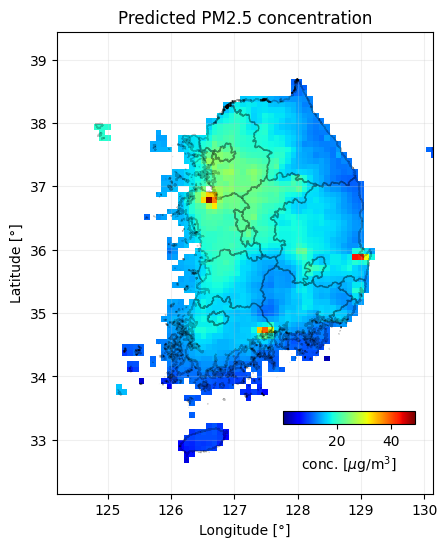

In [43]:
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 바다 지역 마스크 생성
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

# define colormap and make it white for zero values
cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

y_preds_sq = y_preds[200].squeeze()
pm25_conc_map_w_lines = np.where(mask==1, y_preds_sq, 0)[::-1]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.imshow(
    pm25_conc_map_w_lines,
    cmap=cmap_white,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    vmin=0.001)
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_title(f'Predicted PM2.5 concentration')
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='PM2.5 ($\mu g/m^3$)')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
plt.show()

In [46]:
y_preds_mean_df

,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,bnd_0.50,...,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00,bnd_1.00
Seoul,18.452793,17.911535,18.480822,17.906376,17.340219,18.113295,17.516708,18.551596,17.064335,18.803120,...,24.534037,23.742077,24.648592,24.360600,24.885118,24.338261,23.304304,24.320803,23.182079,24.126133
Incheon,11.180546,10.806211,11.214011,11.043966,11.172320,11.121849,11.014288,11.388997,10.679728,11.155006,...,17.650539,17.599842,17.423120,17.487207,17.746567,17.563101,17.040239,17.416275,17.032364,17.608816
Busan,10.707955,10.541459,11.154064,10.902303,10.709360,9.961276,10.635813,11.183602,9.875612,9.860785,...,14.877150,14.289995,14.244084,14.481999,14.389865,14.508888,14.421389,14.151728,14.319858,15.033075
Daegu,14.165167,14.060093,14.647984,14.359376,14.033499,13.464756,13.827350,13.743388,12.402832,13.086171,...,18.100647,17.578136,17.969990,18.300323,17.388479,18.426939,17.983797,18.279099,17.555273,18.619818
Gwangju,11.535802,10.676267,11.808743,11.526515,12.080563,11.304124,10.717271,11.087491,10.089989,10.807874,...,16.945555,16.558533,16.077394,16.536619,16.683195,16.536060,16.323328,17.035774,16.613268,16.775398
Gyeonggi,15.104291,14.951032,15.363712,14.615930,14.443142,14.950370,14.403317,15.386719,14.025877,15.248753,...,21.930178,21.195320,21.706890,21.702906,22.033445,21.644505,20.713394,21.903902,20.756018,21.724876
Gangwon,9.060450,9.223657,9.354288,8.852880,8.735906,9.205586,8.485825,9.263043,8.701205,9.577868,...,15.527430,15.075091,15.301437,15.556423,15.613357,15.552095,14.858658,15.738682,14.908384,15.674235
Chung-Buk,14.443469,13.994523,14.859006,14.529324,14.433249,14.343025,13.629345,14.107141,13.280943,14.151711,...,19.987066,19.352432,18.938910,19.314316,19.413305,19.416265,18.600916,19.979237,18.985971,19.861118
Chung-Nam,14.953671,13.454061,15.570300,15.179623,15.555355,15.075343,14.510228,14.823962,13.833344,13.256368,...,20.392063,19.972597,19.668516,20.000292,20.577513,20.327518,18.751936,20.682196,19.180727,20.671734
Gyeong-Buk,11.721510,11.676905,12.380349,12.255657,11.322438,11.302204,11.428329,11.457773,10.086960,11.079136,...,17.097820,16.473797,17.110107,17.267725,16.039742,17.091818,16.740797,16.975834,16.182011,17.478363
